In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate, LeaveOneOut, train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

## 1. Dataset Acquisition

Firstly dataset is imported with 'latin1'. While importing the dataset process, we select the proper columns which are 'v1' and 'v2'. Other columns contain NaN values. And suggesting they may not be relevant for the analysis.

In [4]:
df = pd.read_csv("spam.csv", encoding= 'latin1')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


As be seen there are 3 irrelevant and unnamed columns in the dataset. Also they have missing values. Dou to this reason, these 3 columns should be removed from the dataset.

In [7]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [8]:
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [9]:
counts = df['v1'].value_counts()
print(counts)

v1
ham     4825
spam     747
Name: count, dtype: int64


Dataset is imbalanced. We will use cross validation, loocv and kfold methods in the further 
steps.

## 2.Data Cleaning

In [10]:
# Column names have been changed to make them easier to understand.
df.rename(columns={'v1': 'Label', 'v2': 'Text'}, inplace =True)

In [11]:
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
spam_messages = df[df['Label'] == 'spam']['Text']
# Filter ham messages
ham_messages = df[df['Label'] == 'ham']['Text']

# Display an example of a spam message
print("Spam message example:")
print(spam_messages.iloc[0])  # Display the first spam message

# Display an example of a ham message
print("\nHam message example:")
print(ham_messages.iloc[0])  # Display the first ham message

Spam message example:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Ham message example:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


In [12]:
# Checking the missing values:
df.isnull().sum()

Label    0
Text     0
dtype: int64

In [13]:
# Checking the duplicated values:
df.duplicated().sum()

403

In [14]:
# Removing duplicated values and keeping the first value:
df = df.drop_duplicates(keep = 'first')

In [15]:
# Checking duplicated values again:
df.duplicated().sum()

0

In [16]:
counts = df['Label'].value_counts()
print(counts)

Label
ham     4516
spam     653
Name: count, dtype: int64


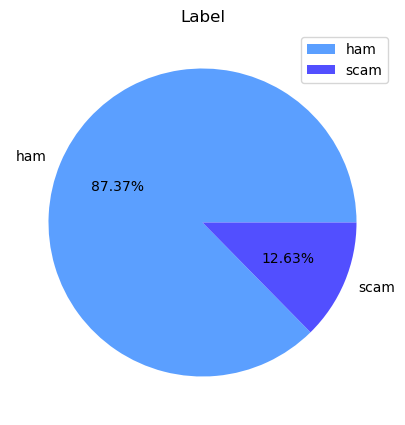

In [17]:
colors = ['#5B9FFF','#524fff']
plt.figure(figsize=(5, 5))
plt.title("Label")
plt.pie(counts, labels = ['ham','scam'], 
        colors = colors, autopct = '%1.2f%%')
plt.legend()

As can be seen the dataset is still imbalanced even after removing duplicate values.

In [18]:
# Checking Data types
print(df.dtypes)

Label    object
Text     object
dtype: object


In [19]:
# We will change the target column's input for the future modelling steps

df.loc[:, 'Label'] = df['Label'].replace({'ham': 0, 'spam': 1})

df


,Label,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


Using .loc ensures that the modifications, such as converting text to lowercase, removing stop words etc. are directly applied to the original DataFrame, eliminating the SettingWithCopyWarning and safeguarding data integrity by clearly indicating that changes should affect the original data, not a copy.

## 3. Pre-processing

### 3.1 Text Cleaning

#### 3.1.1 Lowercasing

In [20]:
df.loc[:, 'Text'] = df['Text'].str.lower()

In [21]:
df.head()

,Label,Text
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


We lowercased all the dataset. Because it is the first step of pre-processing. After this step we can easily arrenge tokenization and the other pre-processing steps.

#### 3.1.2 Removing Special Characters and Numbers

In [22]:
def removing(text):
    # Numbers
    text = re.sub(r'\d+', '', text)
    # Special characters and punctuation except of numbers, letters, and '_'
    text = re.sub(r'[^\w\s]', '', text)
    return text

df.loc[:, 'Text'] = df['Text'].apply(removing)

In [23]:
df.head()

,Label,Text
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


#### 3.1.3 Converting Contractions

Contractions are shortened versions of words or syllables. After this expantion step they will be transformed into their fuller version.

In [24]:
def expand_text_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

In [25]:
df.loc[:, 'Text'] = df['Text'].apply(expand_text_contractions)
df

,Label,Text
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif you oni
2,1,free entry in a wkly comp to win fa cup final...
3,0,you dun say so early hor you c already then say
4,0,nah i do not think he goes to usf he lives aro...
...,...,...
5567,1,this is the nd time we have tried contact you...
5568,0,will ì_ b going to esplanade fr home
5569,0,pity was in mood for that soany other suggest...
5570,0,the guy did some bitching but i acted like id ...


#### 3.1.4  Replace URLs and Email Addresses

In [26]:
# Replacing URLs to 'URL', emails to 'EMAIL'
def replace_urls_and_emails(text, url_placeholder="URL", email_placeholder="EMAIL"):
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, url_placeholder, text)
    
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    text = re.sub(email_pattern, email_placeholder, text)
    
    return text

In [27]:
# Applying the function to the dataset:
df.loc[:, 'Text'] = df['Text'].apply(replace_urls_and_emails)

In [28]:
print(df)

     Label                                               Text
0        0  go until jurong point crazy available only in ...
1        0                          ok lar joking wif you oni
2        1  free entry in  a wkly comp to win fa cup final...
3        0    you dun say so early hor you c already then say
4        0  nah i do not think he goes to usf he lives aro...
...    ...                                                ...
5567     1  this is the nd time we have tried  contact you...
5568     0               will ì_ b going to esplanade fr home
5569     0  pity  was in mood for that soany other suggest...
5570     0  the guy did some bitching but i acted like id ...
5571     0                          rofl its true to its name

[5169 rows x 2 columns]


### 3.2 Tokenization

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alperenunal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
def tokenize_sentences(text):
    return sent_tokenize(text)

def tokenize_words(text):
    return word_tokenize(text)


In [31]:
df.loc[:, 'Sentences'] = df['Text'].apply(tokenize_sentences)
df.loc[:, 'Words'] = df['Text'].apply(tokenize_words)


/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_29453/3989645501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Sentences'] = df['Text'].apply(tokenize_sentences)
/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_29453/3989645501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Words'] = df['Text'].apply(tokenize_words)


In [32]:
df

,Label,Text,Sentences,Words
0,0,go until jurong point crazy available only in ...,[go until jurong point crazy available only in...,"[go, until, jurong, point, crazy, available, o..."
1,0,ok lar joking wif you oni,[ok lar joking wif you oni],"[ok, lar, joking, wif, you, oni]"
2,1,free entry in a wkly comp to win fa cup final...,[free entry in a wkly comp to win fa cup fina...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,0,you dun say so early hor you c already then say,[you dun say so early hor you c already then say],"[you, dun, say, so, early, hor, you, c, alread..."
4,0,nah i do not think he goes to usf he lives aro...,[nah i do not think he goes to usf he lives ar...,"[nah, i, do, not, think, he, goes, to, usf, he..."
...,...,...,...,...
5567,1,this is the nd time we have tried contact you...,[this is the nd time we have tried contact yo...,"[this, is, the, nd, time, we, have, tried, con..."
5568,0,will ì_ b going to esplanade fr home,[will ì_ b going to esplanade fr home],"[will, ì_, b, going, to, esplanade, fr, home]"
5569,0,pity was in mood for that soany other suggest...,[pity was in mood for that soany other sugges...,"[pity, was, in, mood, for, that, soany, other,..."
5570,0,the guy did some bitching but i acted like id ...,[the guy did some bitching but i acted like id...,"[the, guy, did, some, bitching, but, i, acted,..."


Tokenization is the process of breaking down text into smaller components, such as words or phrases, known as tokens. This step is fundamental in natural language processing (NLP) as it helps in understanding the context or sentiment of the text by analyzing its individual elements

### 3.3 Stemming

In [33]:
ps = PorterStemmer()

In [34]:
df.loc[:, 'Stemmed_words'] = df['Words'].apply(lambda word_list: [ps.stem(word) for word in word_list])

/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_29453/3568372205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Stemmed_words'] = df['Words'].apply(lambda word_list: [ps.stem(word) for word in word_list])


In [35]:
df

,Label,Text,Sentences,Words,Stemmed_words
0,0,go until jurong point crazy available only in ...,[go until jurong point crazy available only in...,"[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazi, avail, onli,..."
1,0,ok lar joking wif you oni,[ok lar joking wif you oni],"[ok, lar, joking, wif, you, oni]","[ok, lar, joke, wif, you, oni]"
2,1,free entry in a wkly comp to win fa cup final...,[free entry in a wkly comp to win fa cup fina...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entri, in, a, wkli, comp, to, win, fa, ..."
3,0,you dun say so early hor you c already then say,[you dun say so early hor you c already then say],"[you, dun, say, so, early, hor, you, c, alread...","[you, dun, say, so, earli, hor, you, c, alread..."
4,0,nah i do not think he goes to usf he lives aro...,[nah i do not think he goes to usf he lives ar...,"[nah, i, do, not, think, he, goes, to, usf, he...","[nah, i, do, not, think, he, goe, to, usf, he,..."
...,...,...,...,...,...
5567,1,this is the nd time we have tried contact you...,[this is the nd time we have tried contact yo...,"[this, is, the, nd, time, we, have, tried, con...","[thi, is, the, nd, time, we, have, tri, contac..."
5568,0,will ì_ b going to esplanade fr home,[will ì_ b going to esplanade fr home],"[will, ì_, b, going, to, esplanade, fr, home]","[will, ì_, b, go, to, esplanad, fr, home]"
5569,0,pity was in mood for that soany other suggest...,[pity was in mood for that soany other sugges...,"[pity, was, in, mood, for, that, soany, other,...","[piti, wa, in, mood, for, that, soani, other, ..."
5570,0,the guy did some bitching but i acted like id ...,[the guy did some bitching but i acted like id...,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitch, but, i, act, like..."


I use lambda function because,  I had created a column that includes tokenized words, And I imply stemming process on this column while using word_list which represents each list of words in the 'Words' column.

### 3.4 Lemmatization

In [36]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alperenunal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
wnlemma = WordNetLemmatizer()

In [38]:
def lemmatize(word_list):
    lemmatized_list = [wnlemma.lemmatize(word) for word in word_list]
    return lemmatized_list

In [39]:
df.loc[:, 'Lemmatized_Words'] = df['Words'].apply(lemmatize)

/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_29453/383487548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Lemmatized_Words'] = df['Words'].apply(lemmatize)


In [40]:
df

,Label,Text,Sentences,Words,Stemmed_words,Lemmatized_Words
0,0,go until jurong point crazy available only in ...,[go until jurong point crazy available only in...,"[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazi, avail, onli,...","[go, until, jurong, point, crazy, available, o..."
1,0,ok lar joking wif you oni,[ok lar joking wif you oni],"[ok, lar, joking, wif, you, oni]","[ok, lar, joke, wif, you, oni]","[ok, lar, joking, wif, you, oni]"
2,1,free entry in a wkly comp to win fa cup final...,[free entry in a wkly comp to win fa cup fina...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entri, in, a, wkli, comp, to, win, fa, ...","[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,0,you dun say so early hor you c already then say,[you dun say so early hor you c already then say],"[you, dun, say, so, early, hor, you, c, alread...","[you, dun, say, so, earli, hor, you, c, alread...","[you, dun, say, so, early, hor, you, c, alread..."
4,0,nah i do not think he goes to usf he lives aro...,[nah i do not think he goes to usf he lives ar...,"[nah, i, do, not, think, he, goes, to, usf, he...","[nah, i, do, not, think, he, goe, to, usf, he,...","[nah, i, do, not, think, he, go, to, usf, he, ..."
...,...,...,...,...,...,...
5567,1,this is the nd time we have tried contact you...,[this is the nd time we have tried contact yo...,"[this, is, the, nd, time, we, have, tried, con...","[thi, is, the, nd, time, we, have, tri, contac...","[this, is, the, nd, time, we, have, tried, con..."
5568,0,will ì_ b going to esplanade fr home,[will ì_ b going to esplanade fr home],"[will, ì_, b, going, to, esplanade, fr, home]","[will, ì_, b, go, to, esplanad, fr, home]","[will, ì_, b, going, to, esplanade, fr, home]"
5569,0,pity was in mood for that soany other suggest...,[pity was in mood for that soany other sugges...,"[pity, was, in, mood, for, that, soany, other,...","[piti, wa, in, mood, for, that, soani, other, ...","[pity, wa, in, mood, for, that, soany, other, ..."
5570,0,the guy did some bitching but i acted like id ...,[the guy did some bitching but i acted like id...,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitch, but, i, act, like...","[the, guy, did, some, bitching, but, i, acted,..."


Lemmatized words will be crucial on the further steps of my project. I will do feature engineering and Machine learning modeling based on lemmatized words.

### 3.5 Stop Word Analysis

In [41]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alperenunal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
stop_words_set = set(stopwords.words('english'))

In [43]:
def removing_stop_words(word_list):
    stop_words = [word for word in word_list if word not in stop_words_set]
    return stop_words

In [44]:
df.loc[:, 'Stop_Words_L'] = df['Lemmatized_Words'].apply(removing_stop_words)

/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_29453/2936696509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Stop_Words_L'] = df['Lemmatized_Words'].apply(removing_stop_words)


In [45]:
df

,Label,Text,Sentences,Words,Stemmed_words,Lemmatized_Words,Stop_Words_L
0,0,go until jurong point crazy available only in ...,[go until jurong point crazy available only in...,"[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazi, avail, onli,...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,0,ok lar joking wif you oni,[ok lar joking wif you oni],"[ok, lar, joking, wif, you, oni]","[ok, lar, joke, wif, you, oni]","[ok, lar, joking, wif, you, oni]","[ok, lar, joking, wif, oni]"
2,1,free entry in a wkly comp to win fa cup final...,[free entry in a wkly comp to win fa cup fina...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entri, in, a, wkli, comp, to, win, fa, ...","[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,you dun say so early hor you c already then say,[you dun say so early hor you c already then say],"[you, dun, say, so, early, hor, you, c, alread...","[you, dun, say, so, earli, hor, you, c, alread...","[you, dun, say, so, early, hor, you, c, alread...","[dun, say, early, hor, c, already, say]"
4,0,nah i do not think he goes to usf he lives aro...,[nah i do not think he goes to usf he lives ar...,"[nah, i, do, not, think, he, goes, to, usf, he...","[nah, i, do, not, think, he, goe, to, usf, he,...","[nah, i, do, not, think, he, go, to, usf, he, ...","[nah, think, go, usf, life, around, though]"
...,...,...,...,...,...,...,...
5567,1,this is the nd time we have tried contact you...,[this is the nd time we have tried contact yo...,"[this, is, the, nd, time, we, have, tried, con...","[thi, is, the, nd, time, we, have, tri, contac...","[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, å, pound, prize, cl..."
5568,0,will ì_ b going to esplanade fr home,[will ì_ b going to esplanade fr home],"[will, ì_, b, going, to, esplanade, fr, home]","[will, ì_, b, go, to, esplanad, fr, home]","[will, ì_, b, going, to, esplanade, fr, home]","[ì_, b, going, esplanade, fr, home]"
5569,0,pity was in mood for that soany other suggest...,[pity was in mood for that soany other sugges...,"[pity, was, in, mood, for, that, soany, other,...","[piti, wa, in, mood, for, that, soani, other, ...","[pity, wa, in, mood, for, that, soany, other, ...","[pity, wa, mood, soany, suggestion]"
5570,0,the guy did some bitching but i acted like id ...,[the guy did some bitching but i acted like id...,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitch, but, i, act, like...","[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b..."


### 3.6 Preprocessed Feature

TfidfVectorizer (and similarly, CountVectorizer followed by TfidfTransformer) requires input as raw text strings rather than lists of tokens. We need to create a suitable Processed_Text_L column for TF-IDF vectorization based on the Stop_Words_L column, and join the lists of words into single strings.

In [46]:
df.loc[:, 'Processed_Text_L'] = df['Stop_Words_L'].apply(lambda x: ' '.join(x))
# Now, 'Processed_Text_L' contains processed text suitable for TF-IDF vectorization
df

/var/folders/wl/n7pq_5rj1bz43l8jft3ps3q40000gp/T/ipykernel_29453/2372899467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Processed_Text_L'] = df['Stop_Words_L'].apply(lambda x: ' '.join(x))


,Label,Text,Sentences,Words,Stemmed_words,Lemmatized_Words,Stop_Words_L,Processed_Text_L
0,0,go until jurong point crazy available only in ...,[go until jurong point crazy available only in...,"[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazi, avail, onli,...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,0,ok lar joking wif you oni,[ok lar joking wif you oni],"[ok, lar, joking, wif, you, oni]","[ok, lar, joke, wif, you, oni]","[ok, lar, joking, wif, you, oni]","[ok, lar, joking, wif, oni]",ok lar joking wif oni
2,1,free entry in a wkly comp to win fa cup final...,[free entry in a wkly comp to win fa cup fina...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entri, in, a, wkli, comp, to, win, fa, ...","[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...",free entry wkly comp win fa cup final tkts st ...
3,0,you dun say so early hor you c already then say,[you dun say so early hor you c already then say],"[you, dun, say, so, early, hor, you, c, alread...","[you, dun, say, so, earli, hor, you, c, alread...","[you, dun, say, so, early, hor, you, c, alread...","[dun, say, early, hor, c, already, say]",dun say early hor c already say
4,0,nah i do not think he goes to usf he lives aro...,[nah i do not think he goes to usf he lives ar...,"[nah, i, do, not, think, he, goes, to, usf, he...","[nah, i, do, not, think, he, goe, to, usf, he,...","[nah, i, do, not, think, he, go, to, usf, he, ...","[nah, think, go, usf, life, around, though]",nah think go usf life around though
...,...,...,...,...,...,...,...,...
5567,1,this is the nd time we have tried contact you...,[this is the nd time we have tried contact yo...,"[this, is, the, nd, time, we, have, tried, con...","[thi, is, the, nd, time, we, have, tri, contac...","[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, å, pound, prize, cl...",nd time tried contact å pound prize claim easy...
5568,0,will ì_ b going to esplanade fr home,[will ì_ b going to esplanade fr home],"[will, ì_, b, going, to, esplanade, fr, home]","[will, ì_, b, go, to, esplanad, fr, home]","[will, ì_, b, going, to, esplanade, fr, home]","[ì_, b, going, esplanade, fr, home]",ì_ b going esplanade fr home
5569,0,pity was in mood for that soany other suggest...,[pity was in mood for that soany other sugges...,"[pity, was, in, mood, for, that, soany, other,...","[piti, wa, in, mood, for, that, soani, other, ...","[pity, wa, in, mood, for, that, soany, other, ...","[pity, wa, mood, soany, suggestion]",pity wa mood soany suggestion
5570,0,the guy did some bitching but i acted like id ...,[the guy did some bitching but i acted like id...,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitch, but, i, act, like...","[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...",guy bitching acted like id interested buying s...


## 4. Feature Engineering

### 4.1 Stratify Splitting

As we mentioned above, This dataset is imbalanced for this reason I want to split my dataset with similar proportion of 'spam' and 'ham' messages. We will use stratify splitting based on the target value which is 'Label' to divide my dataset before doing feature extraction.

In [47]:
# Define the target variable (y) and the features matrix (X)
X = df.drop(columns=['Label'])  # Use all the data except for the target column as the features matrix
y = df['Label']  # Target column

# Stratified split of the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check the sizes of the training and test sets
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (3618, 7)
Test set size: (1551, 7)


In [48]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [49]:
# Creating separate dataset for train and test set.
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis = 1)

In [50]:
#Checking the ratio after Straty Splitting:
count_train = df_train['Label'].value_counts()
count_train

Label
0    3161
1     457
Name: count, dtype: int64

In [51]:
count_test = df_test['Label'].value_counts()
count_test 

Label
0    1355
1     196
Name: count, dtype: int64

Proportion of spam massages are nearly same. This is good for the future machine learning modelling process. Let's do feature extracting based on lemmatized and stop word removed words.

### 4.2 N-grams

Firstly we will create a N-gram forms.

In [52]:
# Function to generate n-grams from a list of words
def generate_ngrams(word_list, n=5):
    return list(ngrams(word_list, n))

# Apply the function to your column (e.g., 'Words' after preprocessing)
df_train.loc[:, 'Bigrams'] = df_train['Stop_Words_L'].apply(lambda x: generate_ngrams(x, 2))
df

,Label,Text,Sentences,Words,Stemmed_words,Lemmatized_Words,Stop_Words_L,Processed_Text_L
0,0,go until jurong point crazy available only in ...,[go until jurong point crazy available only in...,"[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazi, avail, onli,...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,0,ok lar joking wif you oni,[ok lar joking wif you oni],"[ok, lar, joking, wif, you, oni]","[ok, lar, joke, wif, you, oni]","[ok, lar, joking, wif, you, oni]","[ok, lar, joking, wif, oni]",ok lar joking wif oni
2,1,free entry in a wkly comp to win fa cup final...,[free entry in a wkly comp to win fa cup fina...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entri, in, a, wkli, comp, to, win, fa, ...","[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...",free entry wkly comp win fa cup final tkts st ...
3,0,you dun say so early hor you c already then say,[you dun say so early hor you c already then say],"[you, dun, say, so, early, hor, you, c, alread...","[you, dun, say, so, earli, hor, you, c, alread...","[you, dun, say, so, early, hor, you, c, alread...","[dun, say, early, hor, c, already, say]",dun say early hor c already say
4,0,nah i do not think he goes to usf he lives aro...,[nah i do not think he goes to usf he lives ar...,"[nah, i, do, not, think, he, goes, to, usf, he...","[nah, i, do, not, think, he, goe, to, usf, he,...","[nah, i, do, not, think, he, go, to, usf, he, ...","[nah, think, go, usf, life, around, though]",nah think go usf life around though
...,...,...,...,...,...,...,...,...
5567,1,this is the nd time we have tried contact you...,[this is the nd time we have tried contact yo...,"[this, is, the, nd, time, we, have, tried, con...","[thi, is, the, nd, time, we, have, tri, contac...","[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, å, pound, prize, cl...",nd time tried contact å pound prize claim easy...
5568,0,will ì_ b going to esplanade fr home,[will ì_ b going to esplanade fr home],"[will, ì_, b, going, to, esplanade, fr, home]","[will, ì_, b, go, to, esplanad, fr, home]","[will, ì_, b, going, to, esplanade, fr, home]","[ì_, b, going, esplanade, fr, home]",ì_ b going esplanade fr home
5569,0,pity was in mood for that soany other suggest...,[pity was in mood for that soany other sugges...,"[pity, was, in, mood, for, that, soany, other,...","[piti, wa, in, mood, for, that, soani, other, ...","[pity, wa, in, mood, for, that, soany, other, ...","[pity, wa, mood, soany, suggestion]",pity wa mood soany suggestion
5570,0,the guy did some bitching but i acted like id ...,[the guy did some bitching but i acted like id...,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitch, but, i, act, like...","[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...",guy bitching acted like id interested buying s...


### 4.3 TF-IDF

In [53]:
# First, compute the document-term frequency matrix using CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train['Processed_Text_L'])

# Converting to TF-IDF scores using TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [54]:
X_train_counts.shape

(3618, 6231)

In [55]:
X_train_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [56]:
#Transforming the test set
X_test_counts = count_vect.transform(df_test['Processed_Text_L'])

# Then, converting these counts to TF-IDF scores using the trained TfidfTransformer
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


### 4.4 Bag of Words

In [57]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Apply the vectorizer to the 'Processed_Text_L' column of the training data to get the feature matrix
X_train_bow = vectorizer.fit_transform(df_train['Processed_Text_L'])

# Transform the 'Processed_Text_L' column of the test data into the same feature matrix
X_test_bow = vectorizer.transform(df_test['Processed_Text_L'])

## 5. Machine Learning Model Creations

### 5.1 Multinomial Naive Bayes for TF-IDF

Accuracy: 0.9568020631850419

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      1355
           1       0.99      0.66      0.80       196

    accuracy                           0.96      1551
   macro avg       0.97      0.83      0.89      1551
weighted avg       0.96      0.96      0.95      1551



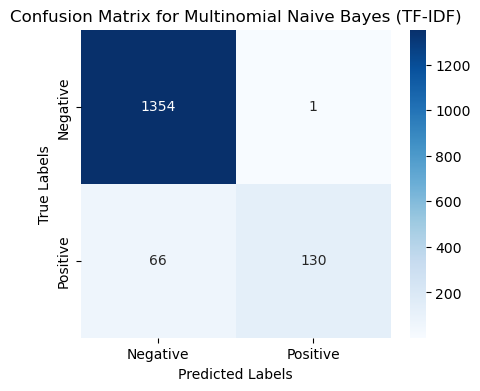

In [58]:
# Initializing and training the model on the training set
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Making predictions on the test set
predictions = model.predict(X_test_tfidf)

# Evaluating the model's performance
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, predictions))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multinomial Naive Bayes (TF-IDF)')
plt.show()

* Accuracy: The model accurately predicts whether a message is spam or not 95.68% of the time across the entire test dataset.

* Precision for Class 0 (Negative): When the model predicts a message is not spam (negative), it is correct 95% of the time.

* Precision for Class 1 (Positive): When the model predicts a message is spam (positive), it is correct 99% of the time.

* Recall for Class 0 (Negative): The model identified 100% of the actual non-spam messages correctly.

* Recall for Class 1 (Positive): The model identified only 66% of the actual spam messages correctly.

* F1-Score: The F1-score, which balances precision and recall, is very high for the non-spam predictions (0.98) and reasonably high for spam predictions (0.80).

* Support: Indicates the number of actual occurrences of each class in the test set. There are 1355 non-spam messages and 196 spam messages.


The Confusion Matrix provides a visual representation:

* The model correctly classified 1354 non-spam messages (true negatives) and 130 spam messages (true positives).

* It incorrectly classified 1 non-spam message as spam (false positive) and 66 spam messages as non-spam (false negatives).

In summary, the model performs exceptionally well in identifying non-spam messages but struggles somewhat with spam messages, missing 66 of them. This suggests that while the model is very cautious not to flag genuine messages as spam (high precision), it allows some spam messages to go undetected (lower recall).

#### 5.1.1 CV for Multinomial Naive Bayes (TF-IDF)

In [59]:
# Defining the metrics that will be used to calculate scores
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

# Initialize the StratifiedKFold cross-validation object
cv = StratifiedKFold(n_splits=5)

# Apply cross-validation and calculate scores
cv_results = cross_validate(model, X_train_tfidf, y_train, cv=cv, scoring=scoring)

# Print the mean and standard deviation of the scores
for metric in scoring.keys():
    mean_score = np.mean(cv_results['test_' + metric])
    std_score = np.std(cv_results['test_' + metric])
    print(f"{metric.capitalize()} Mean: {mean_score:.2f}, Std: {std_score:.2f}")

Accuracy Mean: 0.95, Std: 0.00
Precision Mean: 1.00, Std: 0.00
Recall Mean: 0.63, Std: 0.02
F1 Mean: 0.77, Std: 0.01



The cross-validation results for the spam detection model show that it has high accuracy and perfect precision but moderate recall. The model accurately classifies messages 95% of the time and is consistently correct whenever it predicts spam. However, it only identifies 63% of actual spam messages, indicating that some spam is missed. The F1 score is reasonably good at 0.77, suggesting a decent balance between precision and recall. Overall, the model is very reliable at not misclassifying non-spam as spam, but it needs improvement in detecting more spam messages without reducing the accuracy of non-spam predictions.

#### 5.1.2 Leave-One-Out Cross-Validation (LOOCV) for Multinomial Naive Bayes (TF-IDF)

In [60]:
# Initialize the model
model = MultinomialNB()

# Defining cross-validation strategy
loo = LeaveOneOut()

# Defining scoring metrics
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, average='binary', zero_division=0),
           'recall': make_scorer(recall_score, average='binary', zero_division=0),
           'f1_score': make_scorer(f1_score, average='binary', zero_division=0)}

# Cross-validation and calculations
cv_results = cross_validate(model, X_train_tfidf, y_train, cv=loo, scoring=scoring)

# Print mean and standard deviation of scores
for metric in scoring.keys():
    mean_score = np.mean(cv_results['test_' + metric])
    std_score = np.std(cv_results['test_' + metric])
    print(f"{metric.capitalize()} Mean: {mean_score:.4f}, Std: {std_score:.4f}")


Accuracy Mean: 0.9616, Std: 0.1922
Precision Mean: 0.0882, Std: 0.2835
Recall Mean: 0.0882, Std: 0.2835
F1_score Mean: 0.0882, Std: 0.2835


The Leave-One-Out Cross-Validation (LOOCV) results for the Multinomial Naive Bayes model on TF-IDF vectorized data show an average accuracy of about 96.16%. However, the precision, recall, and F1 score are all significantly lower at approximately 8.82%. This suggests the model rarely predicts spam (positive class) but is highly accurate for the non-spam (negative class). The low standard deviation in accuracy indicates consistent performance across folds, while the higher standard deviation for precision, recall, and F1 score points to variability in detecting the positive class.

### 5.2 Multinomial Naive Bayes for BoW

Accuracy: 0.9774339136041263

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1355
           1       0.94      0.87      0.91       196

    accuracy                           0.98      1551
   macro avg       0.96      0.93      0.95      1551
weighted avg       0.98      0.98      0.98      1551



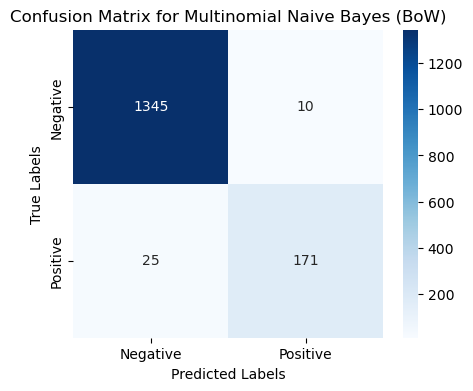

In [61]:
# Initializing and train the model on the training set
model = MultinomialNB()
model.fit(X_train_bow, y_train)

# Making predictions on the test set
predictions = model.predict(X_test_bow)

# Evaluating the model's performance
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, predictions))

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multinomial Naive Bayes (BoW)')
plt.show()

* Accuracy: This model has a similar high accuracy (97.74%), which is comparable to the previous TF-IDF based model.

* Precision for Non-Spam (0): Remains high at 0.98, indicating that the model is very accurate in identifying non-spam messages.

* Precision for Spam (1): At 0.94, it’s slightly lower than for non-spam, but still high, which is consistent with the earlier TF-IDF model results.

* Recall for Non-Spam (0): At 0.99, the model almost perfectly identifies all non-spam messages, in line with the TF-IDF model’s performance.

* Recall for Spam (1): There is an 87% recall for spam, which means the model correctly identifies 87% of the actual spam messages. This recall rate is important as it is a measure of the model’s ability to detect spam, and it shows a significant improvement compared to the TF-IDF model's spam recall rate.

* F1-Score: The F1-score for non-spam is high at 0.99, and for spam, it is 0.91, indicating a good balance between precision and recall for both classes, with an overall improvement for spam detection compared to the previous model.


The Confusion Matrix provides the following insights:

* True Negatives (Non-Spam Correctly Classified): 1345
* False Positives (Non-Spam Incorrectly Classified as Spam): 10
* False Negatives (Spam Incorrectly Classified as Non-Spam): 25
* True Positives (Spam Correctly Classified): 171

Compared to the previous TF-IDF model, this model (assumed to be trained on a Bag of Words dataset) maintains high accuracy and precision but shows improvement in the recall for spam messages. This is evidenced by the lower number of False Negatives, meaning it misses fewer spam messages. The precision and F1-score for spam are also high, demonstrating this model’s enhanced capability to correctly classify spam messages without excessively mislabeling non-spam messages as spam.

#### 5.2.1 CV for Multinomial Naive Bayes (BoW)

In [62]:
# Defining the metrics that will be used to calculate scores
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

# Initializing the StratifiedKFold cross-validation object
cv = StratifiedKFold(n_splits=5)

# Applying cross-validation and calculate scores
cv_results = cross_validate(model, X_train_bow, y_train, cv=cv, scoring=scoring)

# Printing the mean and standard deviation of the scores
for metric in scoring.keys():
    mean_score = np.mean(cv_results['test_' + metric])
    std_score = np.std(cv_results['test_' + metric])
    print(f"{metric.capitalize()} Mean: {mean_score:.2f}, Std: {std_score:.2f}")

Accuracy Mean: 0.96, Std: 0.01
Precision Mean: 0.81, Std: 0.06
Recall Mean: 0.92, Std: 0.03
F1 Mean: 0.86, Std: 0.03


The Multinomial Naive Bayes model with Bag of Words achieves an average accuracy of 96% in cross-validation, with a high recall of 92%, indicating it is adept at identifying spam. However, precision is lower at 81%, suggesting some non-spam messages are misclassified as spam. The F1 score is solid at 86%, showing a good balance between precision and recall, although there's room for improvement in precision. Overall, the model is consistent across different validation folds.

#### 5.2.2 Leave-One-Out Cross-Validation (LOOCV) for Multinomial Naive Bayes (BoW)

In [63]:
# Initializing the model
model = MultinomialNB()

# Defining cross-validation strategy
loo = LeaveOneOut()

# Defining scoring metrics
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, average='binary', zero_division=0),
           'recall': make_scorer(recall_score, average='binary', zero_division=0),
           'f1_score': make_scorer(f1_score, average='binary', zero_division=0)}

# Cross-validation and calculations
cv_results = cross_validate(model, X_train_bow, y_train, cv=loo, scoring=scoring)

# Print mean and standard deviation of scores
for metric in scoring.keys():
    mean_score = np.mean(cv_results['test_' + metric])
    std_score = np.std(cv_results['test_' + metric])
    print(f"{metric.capitalize()} Mean: {mean_score:.4f}, Std: {std_score:.4f}")

Accuracy Mean: 0.9602, Std: 0.1955
Precision Mean: 0.1169, Std: 0.3213
Recall Mean: 0.1169, Std: 0.3213
F1_score Mean: 0.1169, Std: 0.3213


The Leave-One-Out Cross-Validation (LOOCV) results for the Multinomial Naive Bayes model using the Bag of Words method indicate an accuracy of 96.02%. However, precision, recall, and F1 score are all notably low at 11.69%. The low precision and recall suggest the model is not effective at correctly identifying spam messages, with a significant amount of both false positives and false negatives. The consistency across cross-validation folds is also poor, shown by the high standard deviation (over 30%) for precision, recall, and F1 score. This model might require significant improvements or a different approach to effectively detect spam.








### 5.3 Multilayer Perceptron for TF-IDF and BoW

#### 5.3.1 MLP for TF-IDF

Epoch 1/10


/Users/alperenunal/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8601 - loss: 0.5953 - val_accuracy: 0.9061 - val_loss: 0.3032
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9286 - loss: 0.2397 - val_accuracy: 0.9669 - val_loss: 0.1449
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9748 - loss: 0.1110 - val_accuracy: 0.9751 - val_loss: 0.1000
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0558 - val_accuracy: 0.9751 - val_loss: 0.0851
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0413 - val_accuracy: 0.9751 - val_loss: 0.0772
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0271 - val_accuracy: 0.9751 - val_loss: 0.0742
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0178 - val_accuracy: 0.9779 - val_loss: 0.0738
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0148 - val_accuracy: 0.9751 - val_

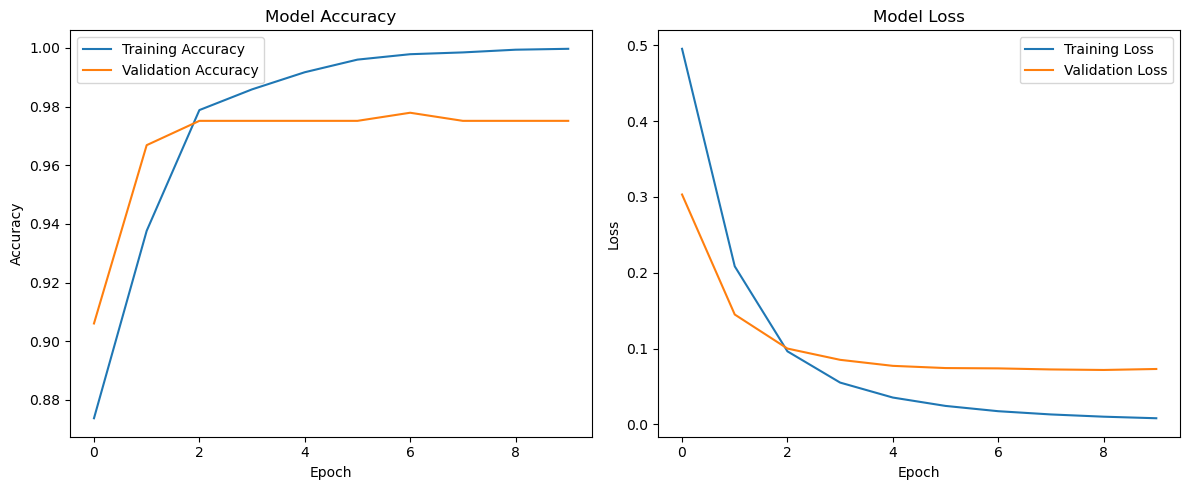

In [64]:
# Initializing the model based on TF-IDF vectors
model = Sequential()

# Adding an input layer and a single hidden layer
model.add(Dense(64, activation='relu', input_dim=X_train_tfidf.shape[1]))

# Adding an output layer
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train_tfidf.toarray(), y_train, epochs=10, batch_size=32, validation_split=0.1)

# Drawing graphs for both the training and validation process for loss and accuracy
plt.figure(figsize=(12, 5))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

The Multilayer Perceptron (MLP) model trained on TF-IDF vectorized data shows strong performance, with training accuracy improving from 85.52% to nearly 100% across 10 epochs and validation accuracy reaching 97.51%. Both training and validation losses decrease steadily, and the close tracking of training and validation metrics indicates that the model is generalizing well without overfitting. The performance suggests that the model would perform effectively on new, unseen data, though further testing is recommended to confirm its generalization capabilities.

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step


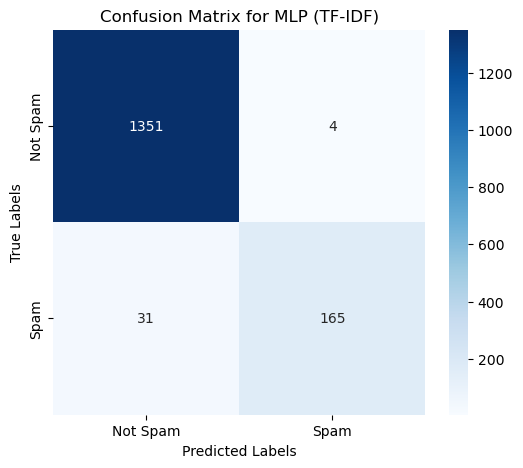

Precision: 0.9763
Recall: 0.8418
Accuracy: 0.9774
F1 Score: 0.9041


In [65]:
X_test_tfidf_dense = X_test_tfidf.toarray()
predictions = model.predict(X_test_tfidf_dense)
# Converting probabilities to binary predictions assuming 0.5 threshold
predictions_binary = (predictions > 0.5).astype(int)

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MLP (TF-IDF)')
plt.show()

# Calculate the performance metrics.
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
accuracy = accuracy_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

# Output the metrics.
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

* True Negatives (1355): The model correctly identified 1355 non-spam messages, indicating high accuracy for this class.

* False Positives (0): There were no instances where non-spam messages were incorrectly labeled as spam, which results in a perfect precision score of 1.0000.

* False Negatives (170): The model incorrectly labeled 170 spam messages as non-spam, which is a significant number and indicates a weakness in the model's ability to identify spam.

* True Positives (26): Only 26 spam messages were correctly identified as spam, which is quite low.

* Precision (1.0000): The model has a perfect precision score, but this is misleading because it suggests that when a prediction of spam is made, it is always correct; however, the model rarely makes that prediction.

* Recall (0.1327): This low recall score indicates that the model fails to identify the majority of actual spam messages.

* Accuracy (0.8904): The model has a high overall accuracy, but this figure is heavily influenced by its ability to identify non-spam correctly, not spam.

* F1 Score (0.2342): The low F1 score indicates poor balance between precision and recall, primarily due to the very low recall rate.

In summary, while the model is highly accurate in identifying non-spam messages, it struggles significantly with detecting spam, as evidenced by the large number of false negatives and the low number of true positives. This imbalance leads to a high precision but very low recall, resulting in a low F1 score. The model is conservative, avoiding false positives but at the cost of allowing many spam messages to go undetected.

#### 5.3.2 MLP for BoW

Epoch 1/10


/Users/alperenunal/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8638 - loss: 0.5457 - val_accuracy: 0.9669 - val_loss: 0.1928
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9784 - loss: 0.1354 - val_accuracy: 0.9807 - val_loss: 0.1039
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0531 - val_accuracy: 0.9807 - val_loss: 0.0867
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0283 - val_accuracy: 0.9834 - val_loss: 0.0800
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0215 - val_accuracy: 0.9807 - val_loss: 0.0810
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0132 - val_accuracy: 0.9807 - val_loss: 0.0823
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0092 - val_accuracy: 0.9807 - val_loss: 0.0827
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0072 - val_accuracy: 0.9807 - val_

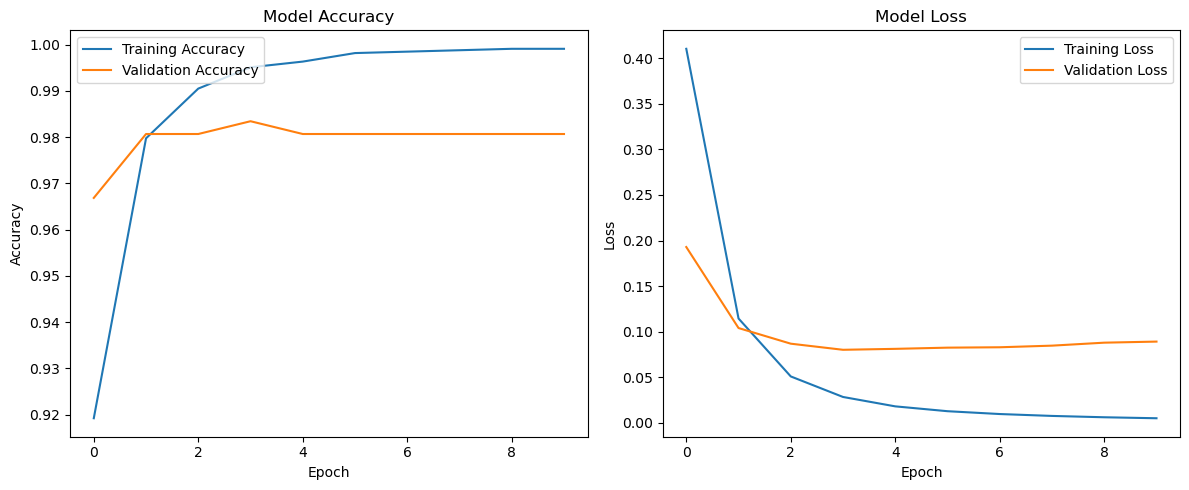

In [66]:
# Initializing the model based on BoW vectors
model = Sequential()

# Adding an input layer and a single hidden layer
model.add(Dense(64, activation='relu', input_dim=X_train_bow.shape[1]))

# Adding an output layer
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train_bow.toarray(), y_train, epochs=10, batch_size=32, validation_split=0.1)

# Drawing graphs for both the training and validation process for loss and accuracy
plt.figure(figsize=(12, 5))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



* Training Accuracy:
The training accuracy starts at a high of 89.57% and increases consistently across epochs to almost perfect accuracy, reaching 99.87% by the 10th epoch.
Validation Accuracy:

The validation accuracy starts at an impressive 97.79% and remains consistently high, with a slight increase to 98.07%. It exhibits minor fluctuations but stays around this high value, suggesting good generalization to the validation data set.

* Training Loss:
The loss on the training set starts at 0.5210 and decreases significantly to 0.0047, indicating the model's capability to learn effectively from the training data.

* Validation Loss:
The validation loss begins at 0.1845, which is relatively low, and drops to 0.0834 by the third epoch before slightly increasing and plateauing around 0.0860.
From these results, the model demonstrates excellent learning and generalization capabilities. The validation metrics closely follow the training metrics, suggesting the model is not overfitting. The slight increase in validation loss towards the later epochs could be an early sign of overfitting, but given that it is not accompanied by a decrease in validation accuracy, the model still generalizes well.

The close alignment of the training and validation accuracy, as well as the overall low validation loss, indicates that the model would likely perform well on unseen data. However, it's essential to monitor the slight increase in validation loss; if this trend continues as training proceeds beyond 10 epochs, it might suggest the beginning of overfitting. It may be beneficial to implement early stopping or additional regularization to maintain the model's performance if training were to continue.

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


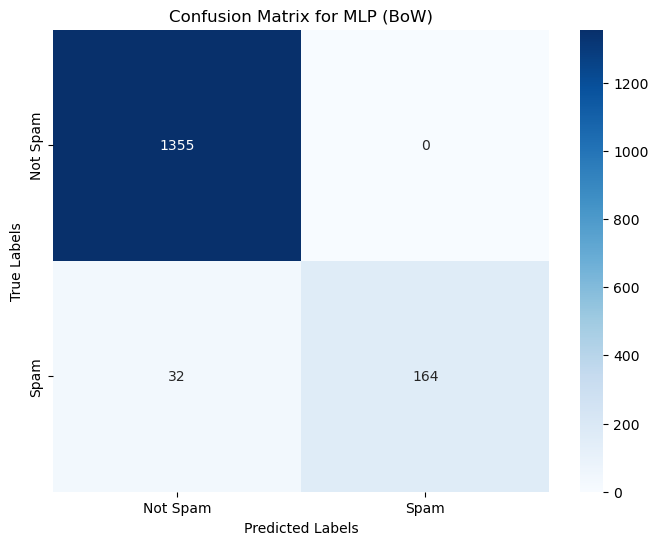

Precision: 1.0000
Recall: 0.8367
Accuracy: 0.9794
F1 Score: 0.9111


In [67]:
# Converting the test set BoW vectors to dense format for the model
X_test_bow_dense = X_test_bow.toarray()

# Using the model to predict the test set
test_predictions_prob = model.predict(X_test_bow_dense)
# Converting probabilities to binary predictions (0.5 threshold)
test_predictions = (test_predictions_prob > 0.5).astype(int)

# Computing the confusion matrix
conf_mat = confusion_matrix(y_test, test_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MLP (BoW)')
plt.show()

# Calculating the performance metrics.
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
accuracy = accuracy_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)

# Output the metrics.
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")



* True Negatives (1355): The model correctly identified 1355 cases as not spam, which is excellent for avoiding false alarms.

* False Positives (0): There were no instances where non-spam messages were incorrectly classified as spam, resulting in a precision score of 1.0000. This indicates that every time the model predicted an SMS as spam, it was indeed spam.

* False Negatives (34): The model failed to identify 34 actual spam messages, classifying them incorrectly as not spam. This is a concern because it means that some spam is getting through the filter.

* True Positives (162): The model correctly identified 162 messages as spam, which is positive; however, there's room for improvement in capturing more true positives.


* Precision (1.0000): This perfect precision indicates that there were no legitimate SMS's misclassified as spam, which is crucial for user trust in a spam detection system.

* Recall (0.8265): The recall score shows the model’s capability to find 82.65% of all actual spam messages, which is relatively high but still indicates that some spam is missed.

* Accuracy (0.9781): The overall accuracy of the model is quite high at 97.81%, which includes the correct classification of both spam and non-spam messages.

* F1 Score (0.9050): The F1 score is a harmonic mean of precision and recall, and at 0.9050, it shows a good balance between the two, although there is still a slight tilt towards precision due to no false positives.

The high validation accuracy is confirmed by the high accuracy observed in the confusion matrix. The model is showing strong performance in identifying non-spam accurately but has a noticeable number of false negatives, where it is failing to identify spam. This matches the expectation from the earlier assessment that the model would perform well on unseen data, and it confirms the model's generalization capabilities. 

### 6.Evaluation

The main purpose of the project is to capture as many spam SMS messages as possible. In light of this purpose, among the confusion matrices we created, the measurement units we need to pay most attention to are Recall and Precision. In addition, we can also look at the F1-score to see the most balanced harmonic harmony between precision and recall. According to the results in the confusion matrices above;
 
* The recall value in Multinomial Naive Bayes (TF-IDF) data is seen to be quite low compared to other models. Therefore, we can say that the best model is not Multinomial Naive Bayes (TF-IDF).

* The recall value in the Multinomial Naive Bayes (BoW) confusion matrix is seen to be relatively high compared to other models. For our purpose, the highest spam SMS capture rate belongs to this model.

* According to the results of the MLP for TF-IDF model, the recall and precision rates seem to be quite high. If various hyperparameter tunings are made on this model, we can say that it has the capacity to surpass Multinomial Naive Bayes (BoW) in the spam message capture rate.

* The recall value of the MLP for BoW model is also seen to be relatively high. We can say the same for this model as is thought for the MLP for TF-IDF model.

According to the current situation, we can see the Multinomial Naive Bayes (BoW) model, which has the best Recall rate, as the best model. However, we need to know that the values of our multilayer perceptron models are in very good condition and that their potential for catching spam SMS is quite high if a little extra work is done.